# I. Разложение ошибки на смещение и разброс


## Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

**Проще**

Для оценки математического ожидания $\mathbb{E}_{\bar x} f(\bar x)$ функции $f$ от многомерной случайной величины $\bar x$, можно приближенно вычислить интеграл, используя выборку $\bar x_1, \dots, \bar x_m$ из распределения $p(\bar x)$, и усреднить значение функции на элементах этой выборки. Для оценки многомерных интегралов объекты лучше генерировать по специальным схемам, но мы будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5 
Этот код генерирует выборку размера 1000 из нормального распределения со средним мат. ожиданием $\mu=5$ и стандартным отклонением $\sigma=3$, используя функцию np.random.normal() из библиотеки NumPy. Затем он вычисляет среднее значение квадрата элементов выборки (x**2).mean() и возвращает этот результат.

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

35.31083130095532

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

Этот код генерирует 1000 выборок размера 10 из многомерного нормального распределения с вектором средних np.ones(10) и матрицей ковариаций np.eye(10) с помощью функции np.random.multivariate_normal() из библиотеки NumPy. Затем к каждой выборке применяется операция возведения в квадрат каждого элемента, затем вычисляется сумма элементов в каждой выборке по оси 1 (то есть по строкам) и затем вычисляется среднее значение этих сумм.

Иными словами, производится генерация 1000 векторов размера 10 из нормального распределения, затем для каждого вектора вычисляется сумму квадратов его элементов, а затем вычисляется среднее значение этих сумм по всем векторам. Результат будет одним числом, которое отражает среднюю сумму квадратов элементов по всем выборкам.

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.37174080473668

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

## Практическая часть

### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$



В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 16) #графики в стандартный вид

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 100, 1000)  # точки для построения графиков 1000 точек 

__1__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

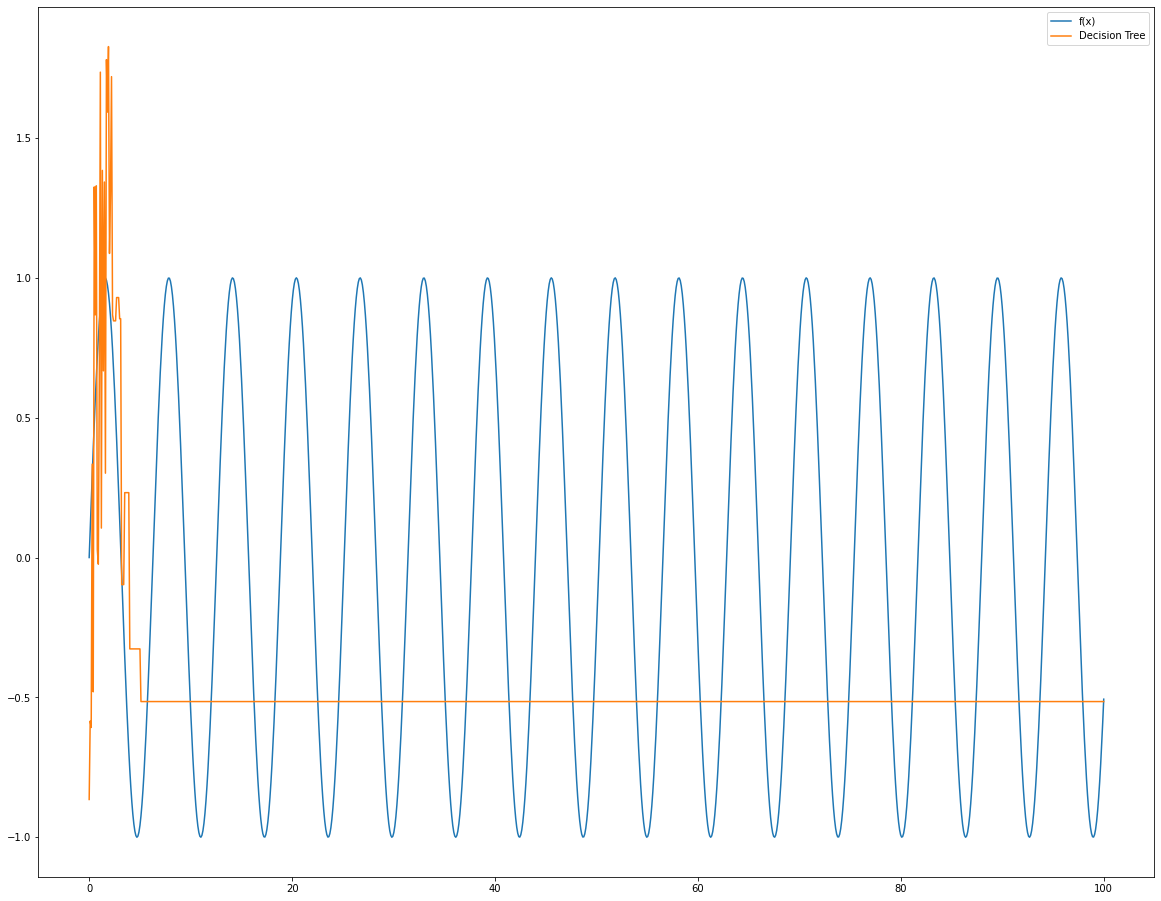

In [6]:
from sklearn.tree import DecisionTreeRegressor
# Генерация выборки и целевых переменных
x = np.random.exponential(size=sample_size)
y = f(x) + np.random.uniform(-1, 1, size=sample_size) # + шум

# Обучение модели и предсказания на linspace
tree = DecisionTreeRegressor()
tree.fit(x[:, np.newaxis], y) #мнимая ось
y_pred = tree.predict(linspace[:, np.newaxis])

# Отрисовка графиков
plt.plot(linspace, f(linspace), label='f(x)')
plt.plot(linspace, y_pred, label='Decision Tree')
plt.legend()
plt.show()

__2:__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

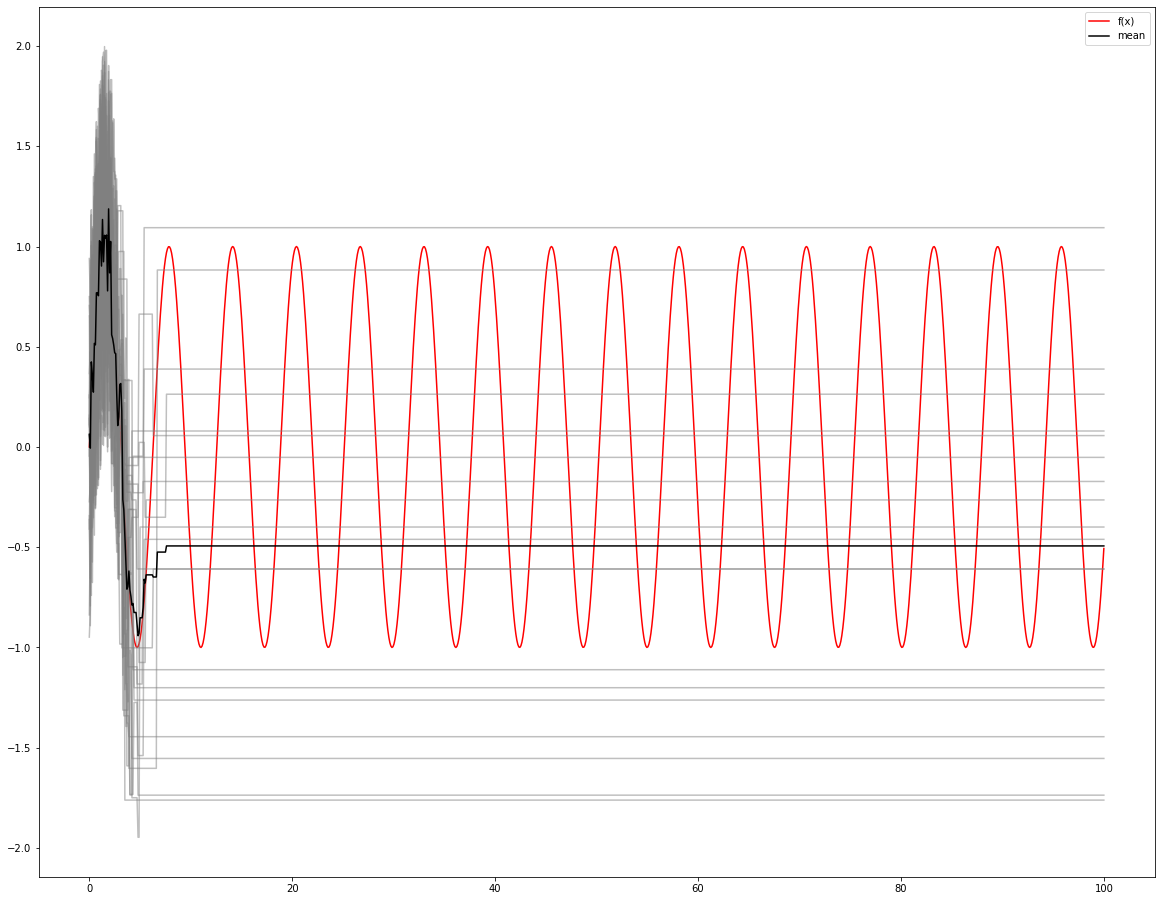

In [7]:
# Создаем пустой массив для хранения прогнозов для каждого дерева
y_preds = np.zeros((samples_num, len(linspace)))

# Создаем цикл для повторения шагов 1-3 samples_num раз
for i in range(samples_num):
    # Генерация выборки и целевых переменных
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, size=sample_size) # + шум

    # Обучение модели и предсказания на linspace
    tree = DecisionTreeRegressor()
    tree.fit(x[:, np.newaxis], y) #мнимая ось
    y_pred = tree.predict(linspace[:, np.newaxis])
    y_preds[i, :] = y_pred

# Отрисовка графиков
plt.plot(linspace, f(linspace), color="red", label="f(x)")

for i in range(samples_num):
    plt.plot(linspace, y_preds[i], color="gray", alpha=0.5)

plt.plot(linspace, np.mean(y_preds, axis=0), color="black", label="mean")

plt.legend()
plt.show()


__3:__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

In [8]:
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 100, 1000)  # точки для построения графиков 1000 точек 

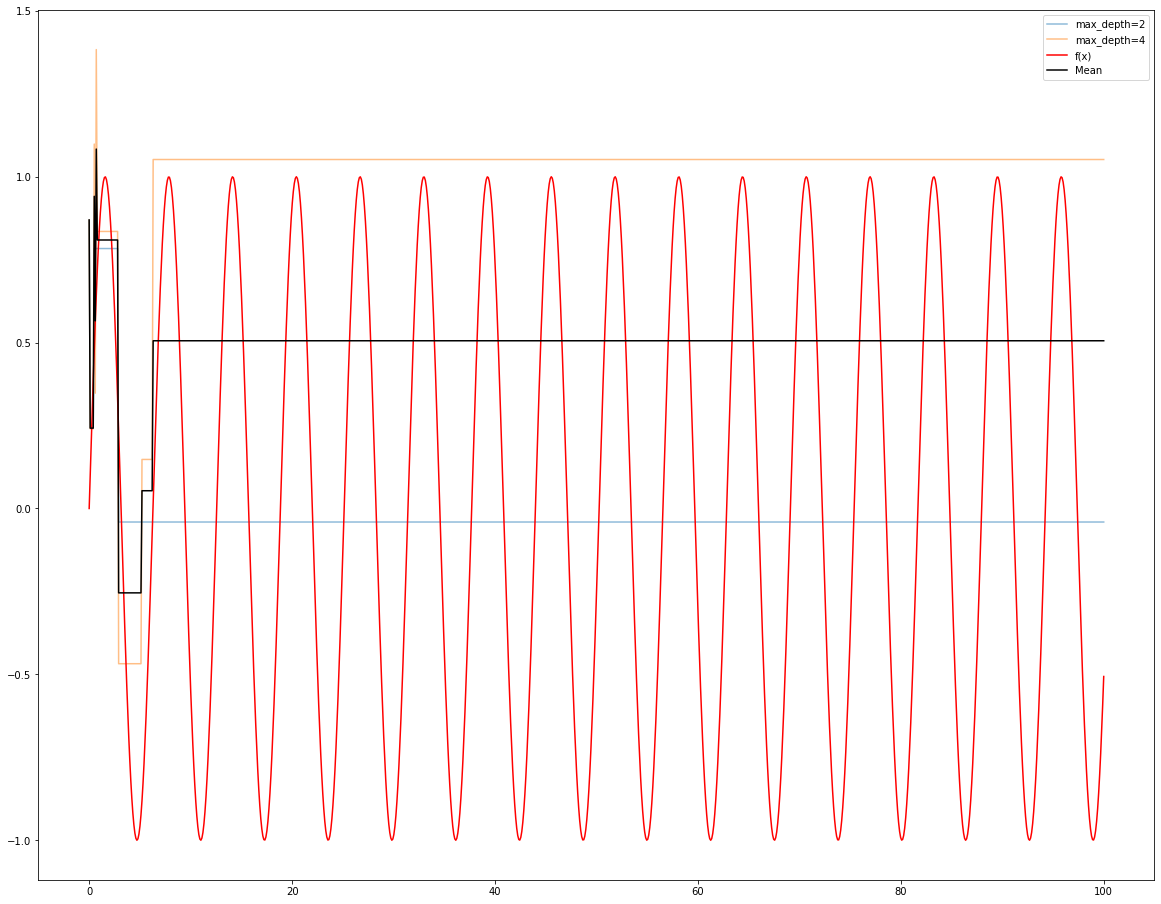

In [9]:
# Генерация выборки и целевых переменных
x = np.random.exponential(size=sample_size)
y = f(x) + np.random.uniform(-1, 1, size=sample_size) # + шум

trees = []
# Обучение модели и предсказания на linspace
for max_depth in [2, 4]:
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x[:, np.newaxis], y) #мнимая ось
    y_pred = tree.predict(linspace[:, np.newaxis])
    trees.append(tree)
    # Отрисовка графиков
    plt.plot(linspace, y_pred, label=f'max_depth={max_depth}', alpha=0.5)

# Отрисовка графика истинной зависимости
plt.plot(linspace, f(linspace), label='f(x)', color='red')

# Усредненная восстановленная зависимость
mean_y_pred = np.mean([tree.predict(linspace[:, np.newaxis]) for tree in trees], axis=0)
plt.plot(linspace, mean_y_pred, label='Mean', color='black')

plt.legend()
plt.show()


__4:__
Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

*Используя только построенные графики, сложно определить какой из рассмотренных случаев имеет более низкое (близкое к нулю) смещение. Можно сказать, что для случая без органичением глубины, средний ответ алгоритмов всех лучше аппроксимировал истинную зависимость, т.е. черная линия всех ближе находится к красной по абсолютной величине на первой картинке.* 
*С другой стороны, отклонения вворх и вниз примерно одинаковы для случаев без ограничения глубины и с ограниением 4, так что, впринципе, можно утверждать, что они имеют близкое к нулю смещение. Всех хуже на второй, где в качестве базовых моделей были выбраны деревья с ограничением глубины 2*.

### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.



__4:__ Реализуйте функцию:

Функция принимает следующие аргументы:


1.   regressor: объект модели, который должен иметь методы fit и predict (например, DecisionTreeRegressor)
2.   dependence_fun: истинная функция, от которой зависит целевая переменная
3. x_generator: функция-генератор, возвращающая выборку признаков
4. noise_generator: функция-генератор, возвращающая выборку шумов
5. sample_size: размер выборки
6. samples_num: количество выборок, которые нужно сгенерировать
7. objects_num: количество объектов, на которых нужно оценить модель

Примечание: в качестве функции-генератора выборки можно использовать любую функцию, которая возвращает массив случайных чисел заданного размера.

In [10]:
#Функция для вычисления смещения и разброса модели

def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=100, samples_num=100, objects_num=50):
    # Генерация выборки объектов и зависимости
    X = x_generator(size=sample_size)
    y = dependence_fun(X)
    # Генерация шума
    noise = noise_generator(size=sample_size)
    # Вычисление y с шумом
    y_n = y + noise.mean()
    # Вычисление мат. ожидания правильного ответа на объекте с шумом
    E_y_with_x = y + np.mean(noise, axis=0)
    mean_prediction = np.zeros(sample_size)
    
    # Цикл для вычисления среднего предсказания модели на объекте
    for i in range(samples_num):
      # Генерация выборки для обучения модели
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        # Обучение модели
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        # Вычисление среднего предсказания модели на объекте
        mean_prediction += tr.predict(X[:, np.newaxis]) / samples_num

    # Вычисление смещения модели
    bias = np.mean((y + noise - mean_prediction) ** 2, axis=0)
    # Разброс
    var_prediction = np.zeros(sample_size)

    # Цикл для вычисления разброса модели на объекте
    for i in range(samples_num):
        # Генерация выборки для обучения модели
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        # Обучение модели
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        # Вычисление разброса модели на объекте
        var_prediction += (tr.predict(X.reshape(-1, 1)) - mean_prediction) ** 2 / samples_num
    # Вычисление разброса модели
    variance = np.mean(var_prediction, axis=0)
    return bias, variance

Параметры:
* regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor, LinearRegression, Lasso, RandomForestRegressor ...)
* dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор такой же длины. Примеры: np.sin, lambda x: x\*\*2.
* x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* sample_size: число объектов в выборке.
* samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x.

Вовращаемые значения:
* Смещение алгоритма regressor (число)
* Разброс алгоритма regressor (число)

_Рекомендации:_ 
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор правильных ответов на нем и вектор зашумленных правильных ответов. $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума (который оценивается генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины sample_size и усреднить предсказания на сгенерированных ранее объектах. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний. Для оценки разброса нужно еще раз сгенерировать samples_num выборок.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

In [44]:
compute_bias_variance(regressor=LinearRegression, dependence_fun=lambda x: x ** 2, noise_generator=lambda size: np.random.normal(0, 1, size=size), x_generator=lambda size: np.random.normal(0, 5, size=size), sample_size=1000)

(1296.5233569654058, 8.715364872973343)

__5 Заполните таблицу.__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [12]:
regressors = [LinearRegression, 
              DecisionTreeRegressor, 
              RandomForestRegressor,
              GradientBoostingRegressor]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              np.random.uniform]

In [13]:
bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

In [14]:
dependence_fun = lambda x:5 * np.sin(10 * x)

for idx_r, regressor in enumerate(regressors):
    for idx_g, generator in enumerate(generators):
        bias.iloc[idx_r, idx_g], variance.iloc[idx_r, idx_g] = compute_bias_variance(regressor=regressor, dependence_fun=dependence_fun,
                                                                                x_generator=generator, noise_generator=generator)
    
print(bias) #Смещение алгоритмов
print("\n")
print(variance) #Разброс алгоритмов

                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression       11.88165        11.236393      12.710428     10.786749
DecisionTree           0.131288         0.132381       0.353188      0.091067
RandomForest           0.390031         0.417436       0.398795      0.099473
GradientBoosting       0.143789          0.52096       0.390598      0.095476


                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression       0.243568         0.369395       0.188046      0.197777
DecisionTree           0.266249         0.377774       0.609037      0.148741
RandomForest           0.411386         0.271405       0.359627      0.078206
GradientBoosting       0.379609         0.557509       0.447265      0.131514


__6 Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

**Ответ**

1. [LR, RF, DB, DT] Каждый алгоритм имеет свои особенности в ранжировке для конкретного распределения, но в общем и целом, можно сказать, что линейная модель (LR) является простой и имеет низкий разброс. Алгоритм случайного леса (RF) хорошо работает за счет усреднения, а остальные (DB и DT) более гибкие и сложные, поэтому имеют больший разброс из-за переобучения и настройки на выбросы.

2. Невозможно получить однозначный ответ на вопрос о влиянии распределения на смещение и разброс модели. Восстановление зависимости из выборки напрямую зависит от распределения, из которого выборка была сгенерирована. Различные распределения имеют различные плотности, при которых некоторые значения получаются чаще, а другие - реже. Поэтому смещение и разброс также зависят от выборки, а не только от распределения, и не существует однозначного ответа на вопрос о влиянии распределения.

3. Для равномерного распределения на интервале [-1, 1] и нормального распределения получаются наилучшие результаты. Это происходит потому, что эти распределения симметричны относительно нуля, поэтому значения получаются как положительные, так и отрицательные с равной вероятностью. При использовании синуса с множителем 10 в нормальном распределении, выбросы увеличиваются, и это приводит к переобучению деревьев, которые настраиваются на эти выбросы.

__6*__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [15]:
samp_size_stat = [[], [], [], []] # LR, DT, RF, GB
samp_num_stat = [[], [], [], []]
obj_num_stat = [[], [], [], []]

for i in range(1, 60, 10):
    for idx_r, regressor in enumerate(regressors):
        samp_size_stat[idx_r].append(compute_bias_variance(sample_size=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))
    for idx_r, regressor in enumerate(regressors):
        samp_num_stat[idx_r].append(compute_bias_variance(samples_num=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))
    for idx_r, regressor in enumerate(regressors):
        obj_num_stat[idx_r].append(compute_bias_variance(objects_num=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))

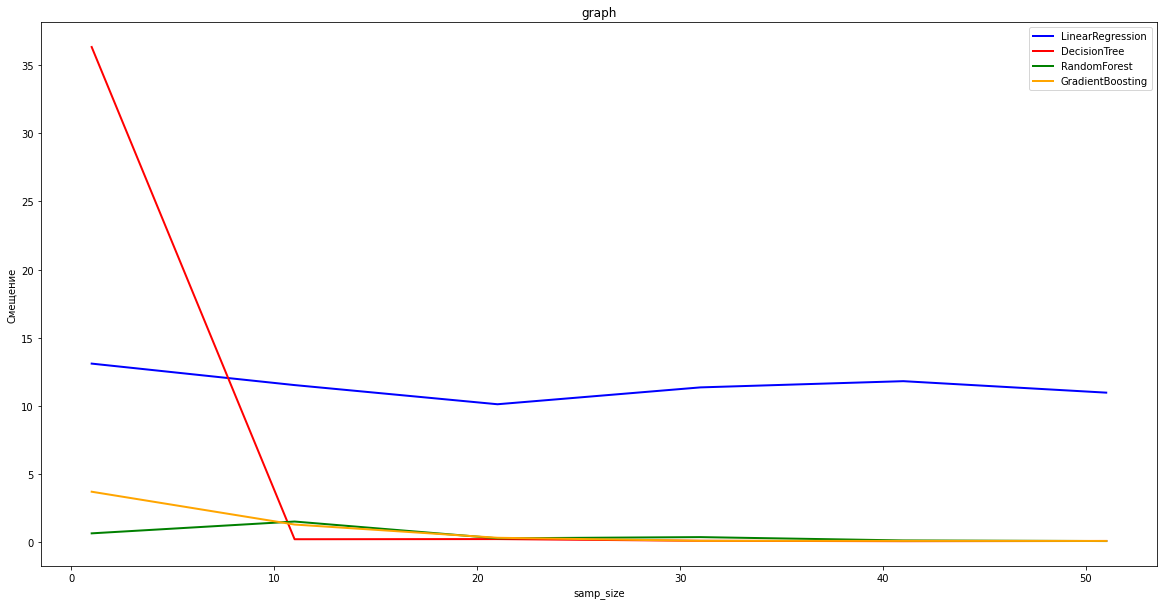

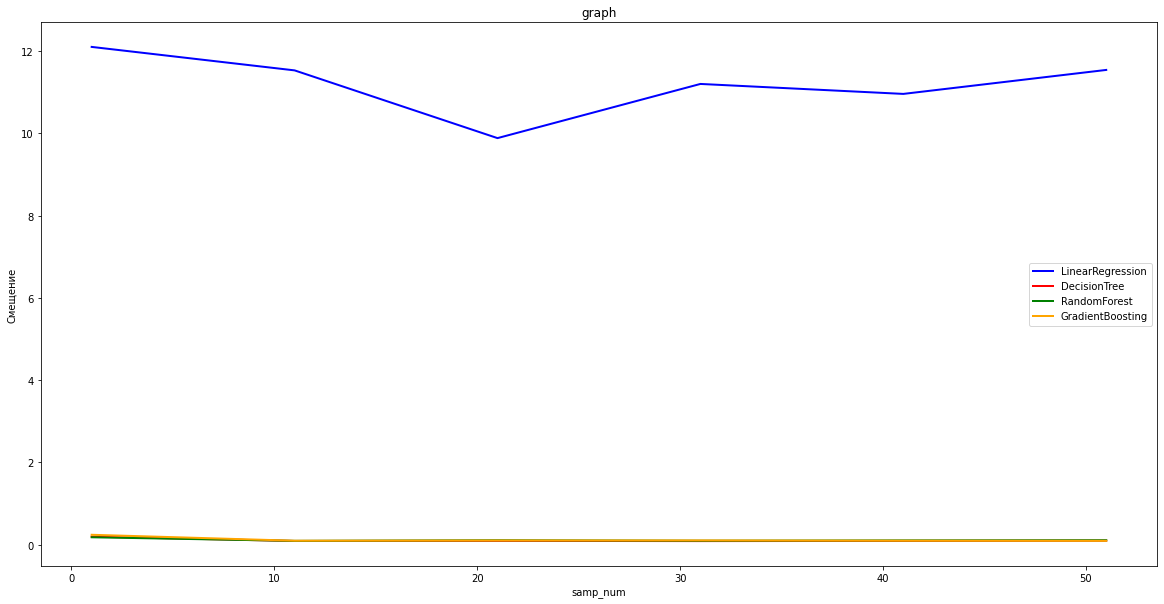

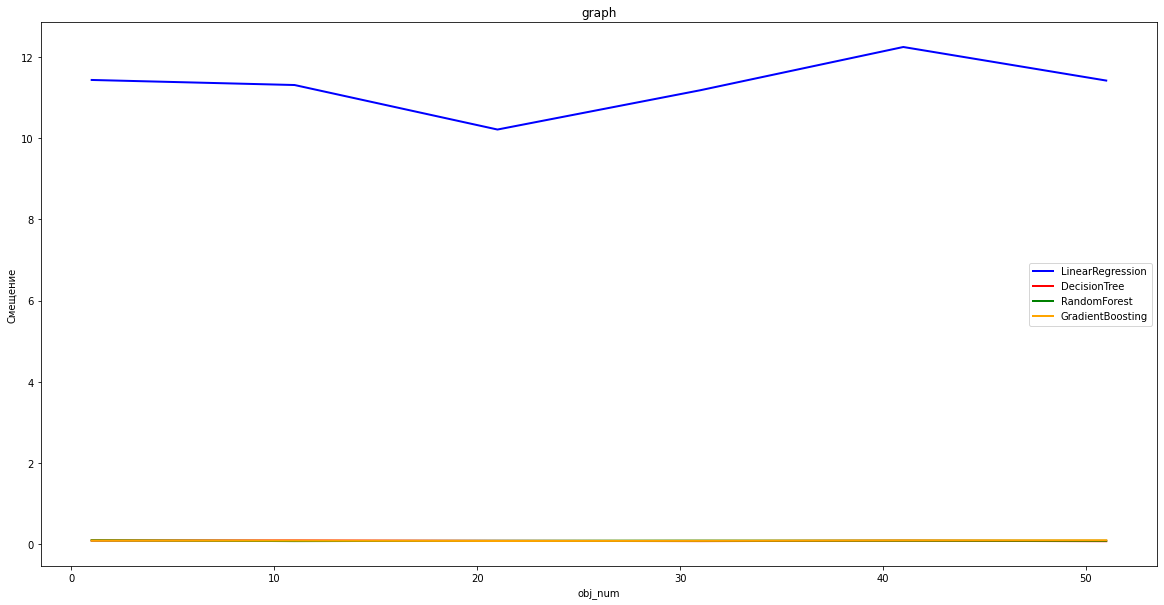

In [16]:
algs = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"]
colors = ["blue", "red", "green", "orange"]
counts = [i for i in range(1, 60, 10)]
param_names = ['samp_size', 'samp_num', 'obj_num']
params_stat = [samp_size_stat, samp_num_stat, obj_num_stat]

for idx_p, param in enumerate(params_stat):
# зависимости bias от количества параметров
    fig, ax = plt.subplots(figsize=(20, 10))
# plt.xlim([0, 1])
    for idx_r, alg in enumerate(algs):
        plt.plot(counts, np.array(params_stat[idx_p][idx_r])[:, 0], c=colors[idx_r], linewidth=2, label=algs[idx_r])
    plt.xlabel(param_names[idx_p])
    plt.ylabel('Смещение')
    plt.title('graph')
    plt.legend()

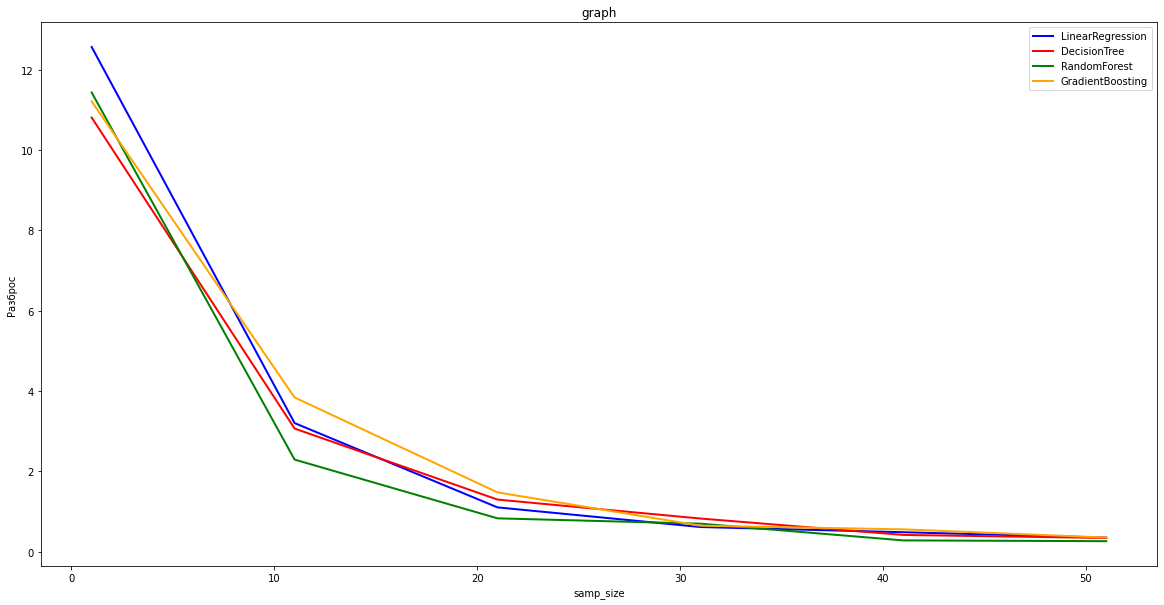

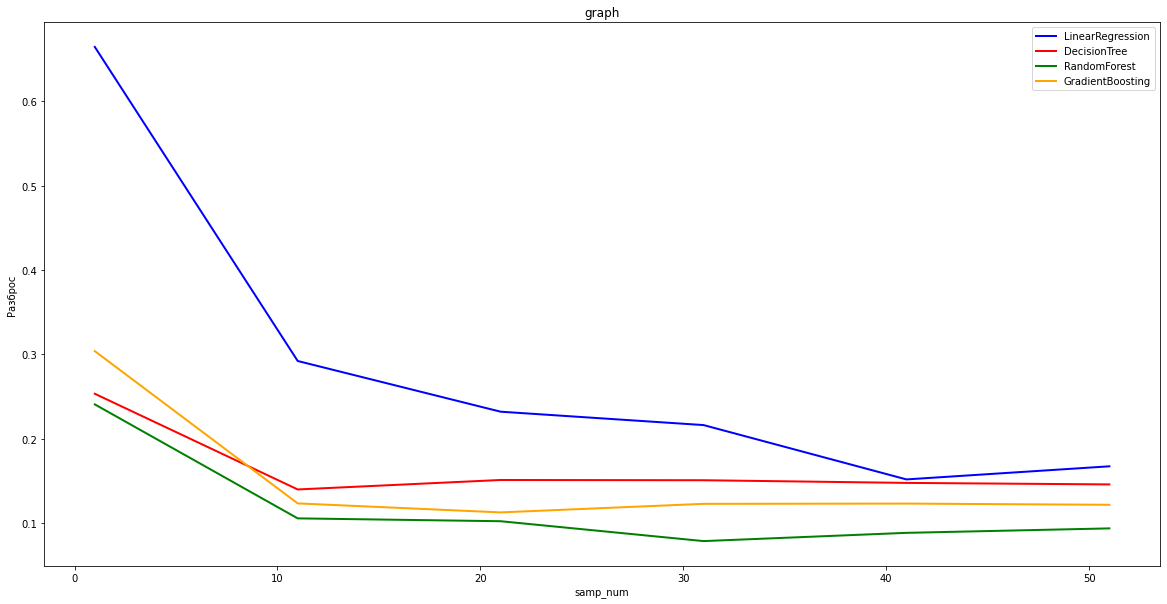

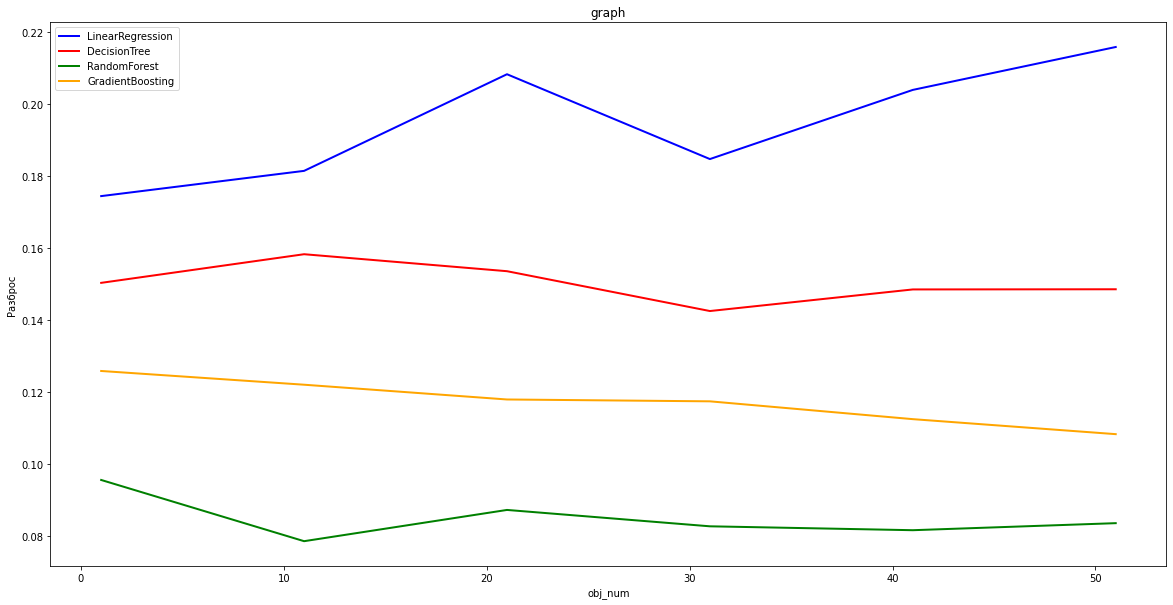

In [17]:
for idx_p, param in enumerate(params_stat):
# зависимости variance от количества параметров
    fig, ax = plt.subplots(figsize=(20, 10))
# plt.xlim([0, 1])
    for idx_r, alg in enumerate(algs):
        plt.plot(counts, np.array(params_stat[idx_p][idx_r])[:, 1], c=colors[idx_r], linewidth=2, label=algs[idx_r])
    plt.xlabel(param_names[idx_p])
    plt.ylabel('Разброс')
    plt.title('graph')
    plt.legend()


Параметры помогают уменьшить разброс оценки bias для всех алгоритмов, кроме LinearRegression. Возможно, при использовании большего количества точек bias для LR также уменьшится (график станет более плавным). Количество объектов практически не влияет на разброс оценки bias для алгоритмов.

Размер выборки (samp_size) существенно влияет на разброс оценки variance для всех алгоритмов, и оценки быстро сходятся к нулю. Количество выборок (samp_num) влияет на разброс оценки variance для всех алгоритмов, за исключением LR, и с увеличением параметра амплитуда колебаний графиков уменьшается. Obj_num не оказывает практически никакого влияния на LR, GB и RF, а для DT немного уменьшает разброс оценки variance.

# II. Решающие деревья своими руками

### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__7__

Реализуйте следующую функцию:

Функция get_gini_for_threshold(threshold_idx) вычисляет значение критерия Джини для заданного порога разбиения множества объектов на два подмножества с индексом порога threshold_idx. Функция возвращает значение критерия Джини для данного порога. Если левое или правое подмножество меньше минимального размера min_samples_leaf, то функция возвращает очень маленькое отрицательное число -10 ** 10 (это значит, что такое разбиение не подходит).

In [18]:
def find_best_split(feature_vector, target_vector, min_samples_leaf=0):
    def get_gini_for_threshold(threshold_idx):
        # Разбиваем множество объектов на левое и правое подмножества
        l = target_vector[permutation][:threshold_idx + 1]
        r = target_vector[permutation][threshold_idx + 1:]
        # Проверяем, достигнуто ли минимальное количество объектов в левом и правом подмножестве
        if (l.shape[0] < min_samples_leaf) or (r.shape[0] < min_samples_leaf):
            return -10 ** 10  # -10000000000
        else:
            # Вычисляем доли объектов каждого класса в левом и правом подмножестве
            p_1_l = np.count_nonzero(l) / l.shape[0]
            p_1_r = np.count_nonzero(r) / r.shape[0]
            p_0_l = 1 - p_1_l
            p_0_r = 1 - p_1_r

            return -(l.shape[0] / target_vector.shape[0]) * (1 - p_1_l ** 2 - p_0_l ** 2) - (r.shape[0] / target_vector.shape[0]) * (1 - p_1_r ** 2 - p_0_r ** 2)
    # Сортируем признаки, сохраняя индексы перестановки (перестановка нужна для получения порогов)
    permutation = feature_vector.argsort()
    # Вычисляем пороги, включая количество элементов каждого уникального значения и их индексы
    thresholds = np.unique(feature_vector[permutation][:-1:], return_index=True, return_counts=True)
    # Вычисляем индексы порогов в перестановке
    thresholds_idx = thresholds[1] + (thresholds[2] - 1)
    # Создаем векторизованную функцию для вычисления критерия Джини для каждого порога
    get_ginis = np.vectorize(get_gini_for_threshold)
    # Получаем вектор значений критерия Джини для каждого порога
    ginis = get_ginis(thresholds_idx)
    max_gini_idx = np.array(ginis).argmax()
    # Возвращаем отсортированные пороги, значения критерия Джини для каждого порога,
    # оптимальный порог, оптимальное значение критерия Джини и индекс оптимального порога
    return thresholds[0], ginis, feature_vector[permutation][thresholds_idx[max_gini_idx]], np.array(ginis).max(), thresholds_idx[max_gini_idx]


Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* Поведение функции в случае константного признака может быть любым
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__8 (0.5 балла)__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [20]:
X = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/students.csv')
X.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


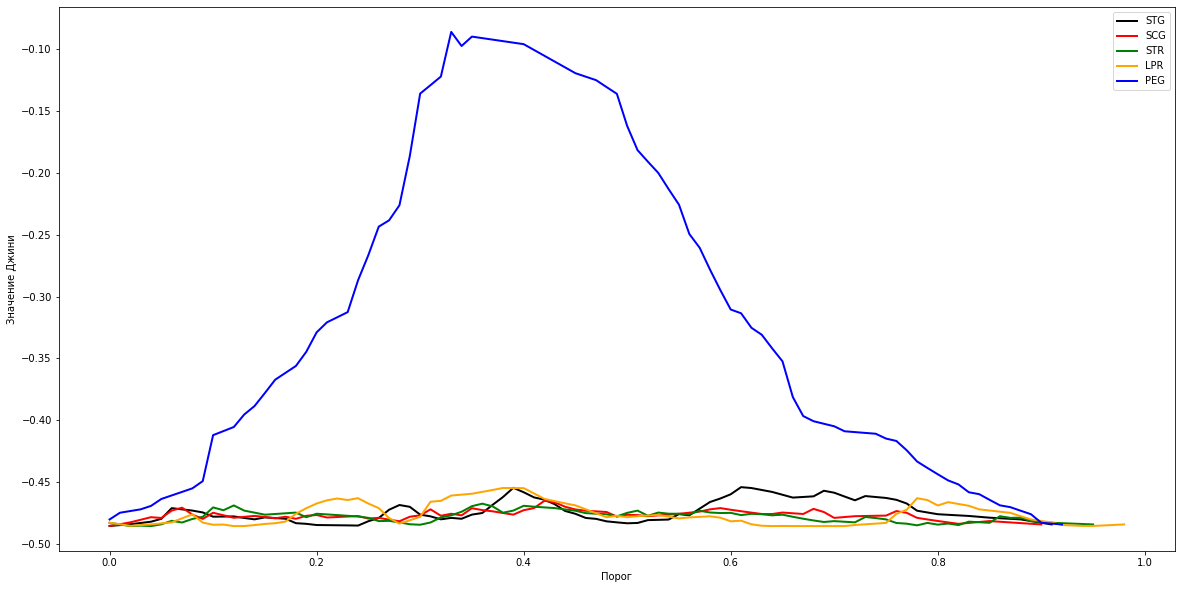

In [21]:
#Раздел на дата и таргет
y = X[' UNS']
X_n = X.drop([' UNS'], axis=1)

#Для графика
fig, ax = plt.subplots(figsize=(20, 10))
features = ["STG", "SCG", "STR", "LPR", "PEG"]
colors = ["black", "red", "green", "orange", "blue"]


for idx, column in enumerate(X_n.columns):
    best_split = find_best_split(X_n[column], y) #использование ранее реализованной функции
    plt.plot(best_split[0], best_split[1], c=colors[idx], linewidth=2, label=features[idx])
plt.xlabel('Порог')
plt.ylabel('Значение Джини')
plt.legend()

<ipython-input-22-374e6ef12a25>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, idx+1)


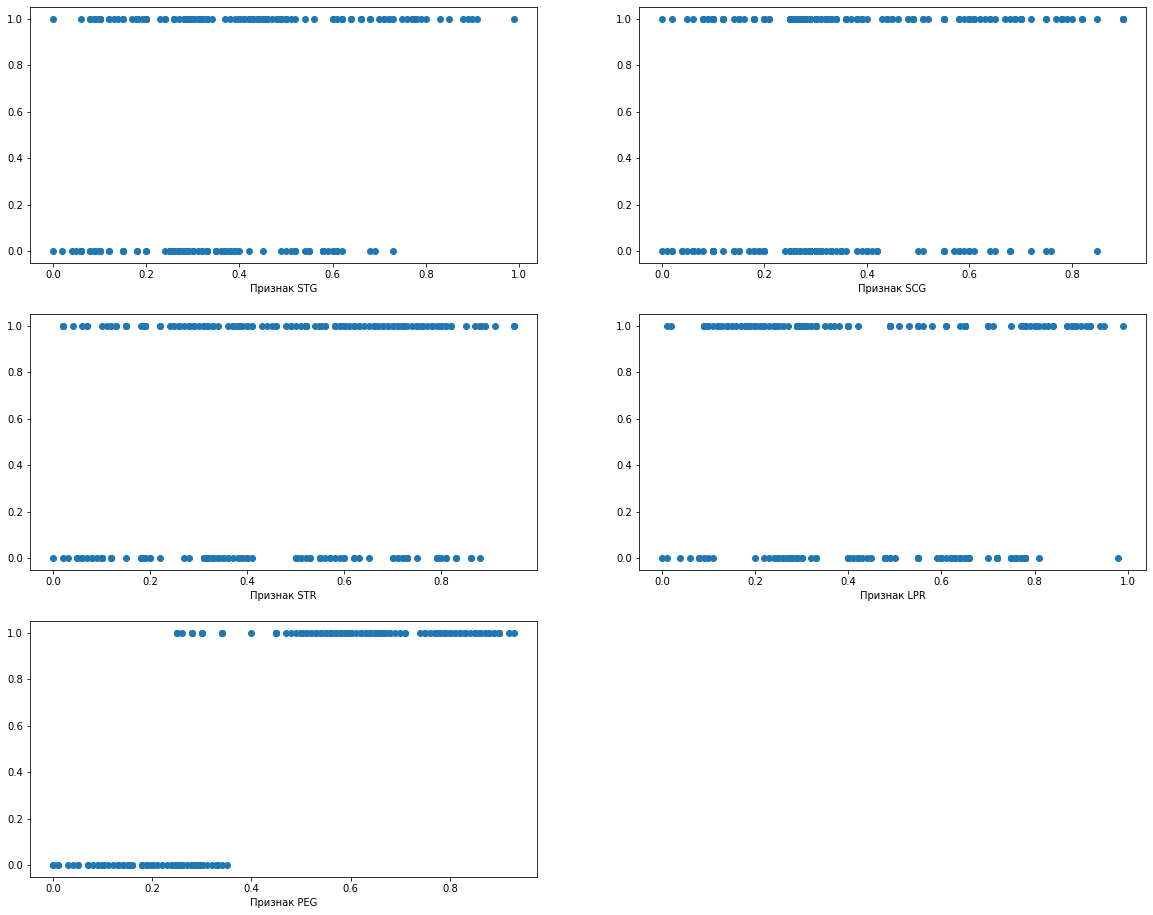

In [22]:
#График Scatter (разброса) Х - значение признака, у - класс.
fig, ax = plt.subplots()
for idx, column in enumerate(X_n.columns):
    plt.subplot(3, 2, idx+1)
    plt.scatter(X[column], y)
    plt.xlabel("Признак " + features[idx])

__9__ Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ** 
В соответствии с кривыми, наилучшим способом разделения выборки является использование признака PEG, соответствующего синей линии. На графике рассеяния для этого признака можно заметить, что выборка резко разделяется при пороге около 0,4, так что справа остается только первый класс, а слева - нулевой класс с небольшими включениями первого класса. Для хороших признаков кривая принимает значения близкие к максимальным на большом количестве порогов, выглядит как горка или выпуклая вверх. У таких признаков значительная разница между своим максимальным и минимальным значением Джини для разных порогов. Для плохих признаков кривая колеблется в окрестности какого-то не очень хорошего значения критерия Джини и имеет маленькую амплитуду. Согласно графику, признаки, которые плохо разделяют выборку и имеют схожие кривые, это красная (SCG), черная (STG), зеленая (STR) и желтая (LPR) линии, в то время как синяя линия (PEG) является отличным признаком.

__10.__
Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов. Будем считать, что одинаковых объектов с разными ответами в выборке нет.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе "Построение дерева". Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное в лекции в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. лекцию). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [23]:
from sklearn.base import BaseEstimator

1. В конструкторе класса инициализируются необходимые атрибуты. types - список булевых значений, где True соответствует категориальному признаку, а False - числовому. max_depth - максимальная глубина дерева, min_samples_split - минимальное количество объектов в узле для разбиения, min_samples_leaf - минимальное количество объектов в листе.
2. В методе fit() проверяется, какие из атрибутов min_samples_split и min_samples_leaf являются числами с плавающей точкой, и пересчитываются в целые значения на основе размера целевого признака y. Затем вызывается рекурсивная функция fit_node(), которая строит дерево.
3. Функция fit_node() делает следующее: если текущая глубина равна максимальной, в узел добавляется случайное значение из y, иначе проверяется, состоит ли y из объектов одного класса, или количество объектов меньше минимального. Если это так, то в узел добавляется соответствующее значение из y. В противном случае узел разбивается на два подузла с помощью выбранного признака и его значения. Для категориальных признаков значение заменяется на соответствующее ему числовое значение, которое задается в словаре cat_vals_dicts, и сохраняется для использования в предсказании. Затем выбирается наилучшее разбиение по критерию Джини, и соответствующее ему значение признака и его порог добавляются в узел. Также создаются подузлы и вызывается функция fit_node() для них.
4. Метод predict() использует рекурсивную функцию predict_node(), которая спускается по дереву и возвращает соответствующее предсказание для входного объекта.

In [24]:
### Шаблон класса, следующего рекомендациям
class DecisionTree(BaseEstimator):
    def __init__(self, types, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self._tree = [] # создаем пустое дерево
        self.types = types # список булевых флагов, показывающих является ли i-й признак категориальным
        self.max_depth = max_depth  # максимальная глубина дерева
        self.min_samples_split = min_samples_split  # минимальное число объектов, необходимых для разделения узла
        self.min_samples_leaf = min_samples_leaf # минимальное число объектов в листе
        self.current_depth = 0 # текущая глубина

    def fit(self, X, y):
        self._tree = []  # создаем пустое дерево
        # приводим тип self.min_samples_split к int, если он float
        self.min_samples_split = ceil(self.min_samples_split * y.shape[0]) if type(self.min_samples_split) is float else self.min_samples_split
        # приводим тип self.min_samples_leaf к int, если он float
        self.min_samples_leaf = ceil(self.min_samples_leaf * y.shape[0]) if type(self.min_samples_leaf) is float else self.min_samples_leaf
        def fit_node(subX, suby, node, c_depth):
        # Если достигнута максимальная глубина, узел содержит только элементы одного класса или в узле меньше минимального
        # количества объектов, добавляем значение класса и останавливаемся
            if (self.current_depth == self.max_depth) or (np.unique(suby).shape[0] == 1) or (suby.shape[0] < self.min_samples_split): #Если у состоит из объектов одинакового класса STOP
                node.append(np.random.choice(suby))
            else:
                c_depth += 1 # увеличиваем глубину
                self.current_depth = max(self.current_depth, c_depth) # обновляем текущую глубину
                subX_for_iteration = np.copy(subX) # создаем копию выборки
                cat_vals_dicts = [dict() for i in range(len(self.types))]  # создаем список словарей для категориальных признаков

                def set_cat_vals(X, y, i):
                    permutation = X.argsort() # получаем порядок сортировки признака
                    # получаем уникальные значения, индексы первых вхождений и количество их вхождений
                    unique, indices, counts = np.unique(X[permutation], return_counts=True, return_index=True)  
                    # Достаем срез Y где значение кат признака из юник
                    y_first_class_counts = [] # список количеств первого класса
                    last_idx = 0
                    for idx in (indices + (counts - 1)):
                        # добавляем количество объектов первого класса
                        y_first_class_counts.append(np.count_nonzero(y[permutation][last_idx:idx + 1:]))
                        last_idx += idx + 1 
                    # получаем вероятности первого класса
                    prob_first_class = np.array(y_first_class_counts) / counts
                    prob_permutation = prob_first_class.argsort()
                    unique = unique[prob_permutation] #отсортированные значения по вероятности (теперь надо заменить значения признака на i его в юнике)
                    for j, cat_value in enumerate(unique): 
                        cat_vals_dicts[i][cat_value] = j

                    def set_i_vals_to_column(x):
                        return cat_vals_dicts[i].get(x)


                    vfunc = np.vectorize(set_i_vals_to_column)
                    return vfunc(X)

                for i, value in enumerate(self.types):
                    if value: #Если значение равно True, то это категориальный признак и нужно выполнить преобразование
                        # Применяем функцию set_cat_vals для преобразования категориальных признаков в числовые.
                        # Результат записываем обратно в матрицу объекты-признаки subX_for_iteration
                        subX_for_iteration[:, i] = set_cat_vals(subX_for_iteration[:, i], y, i)

                #Создание списка разбиений для каждого признака в подматрице
                splits = []
                for feature_i in range(subX_for_iteration.shape[1]):
                    splits.append([feature_i] + list(find_best_split(subX_for_iteration[:, feature_i], suby, self.min_samples_leaf)[2:]))
                
                # Выбор наилучшего разбиения
                best_split = splits[np.array(splits).argmax(axis=0)[2]] #[i, t] для лучшего разбиения
                best_i, best_t, best_t_idx = best_split[0], best_split[1], best_split[3] #[i, t] для лучшего разбиения
                # Заполнение узла
                node.append(best_i) #Заполнили номером признака
                node.append([key for key, val in cat_vals_dicts[best_i].items() if val <= best_t] if self.types[i] else best_t)
                node.append([]) # левое поддерево
                node.append([]) # правое поддерево
                
                #Сортировка данных в подматрице по значению признака и разбиение на подматрицы
                perm = subX_for_iteration[:, best_i].argsort()
                
                #Обучение левого и правого поддеревьев
                l_subX = subX[perm][:best_t_idx + 1]
                l_suby = suby[perm][:best_t_idx + 1]
                r_subX = subX[perm][best_t_idx + 1:]
                r_suby = suby[perm][best_t_idx + 1:]
                
                
                fit_node(l_subX, l_suby, node[2], c_depth)
                fit_node(r_subX, r_suby, node[3], c_depth)

        #Обучение дерева на полных данных
        fit_node(X, y, self._tree, self.current_depth)
    #Метод для предсказания
    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1:
                return node[0]
            else:
                if type(node[1]) is list:
                    return predict_node(x, node[2]) if x[node[0]] in node[1] else predict_node(x, node[3])
                else:
                    return predict_node(x, node[2]) if x[node[0]] <= node[1] else predict_node(x, node[3])
                

        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

__11__ Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [25]:
X_ = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/agaricus-lepiota.data', header = None)
X_.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [26]:
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 30
le = LabelEncoder()
for feature in X_.columns:
    X_[feature] = le.fit_transform(X_[feature])
y = X_[0]
X = X_.drop([0], axis=1)
print('После обработки LE:')
X.head(1)

После обработки LE:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [28]:
MyDT = DecisionTree(types=[1 for i in range(X_train.shape[1])])
MyDT.fit(np.array(X_train), np.array(y_train))

In [29]:
predictions = MyDT.predict(np.array(X_test))
from sklearn.metrics import accuracy_score
print("Точность:", accuracy_score(predictions, y_test), "Глубина:", MyDT.current_depth, "\n", "Дерево:")
MyDT._t ree

Точность: 1.0 Глубина: 8 
 Дерево:


[4,
 [0, 3, 4, 5],
 [4,
  [4],
  [1],
  [19,
   [4, 5],
   [3, [0], [0], [1]],
   [16,
    [3],
    [1],
    [0,
     [3, 4, 5, 2, 0],
     [7, [1], [12, [3], [1], [20, [5, 4], [0], [1]]], [0]],
     [1]]]]],
 [1]]

__11__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [30]:
X_ = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/tic-tac-toe.data', header = None)
X_.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [31]:
le = LabelEncoder()
for feature in X_.columns:
    X_[feature] = le.fit_transform(X_[feature])

y = X_[X_.shape[1] - 1]
X = X_.drop([X_.shape[1] - 1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

<ipython-input-31-15b1e4630dfd>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X_.drop([X_.shape[1] - 1], 1)


In [32]:
 #max_depth

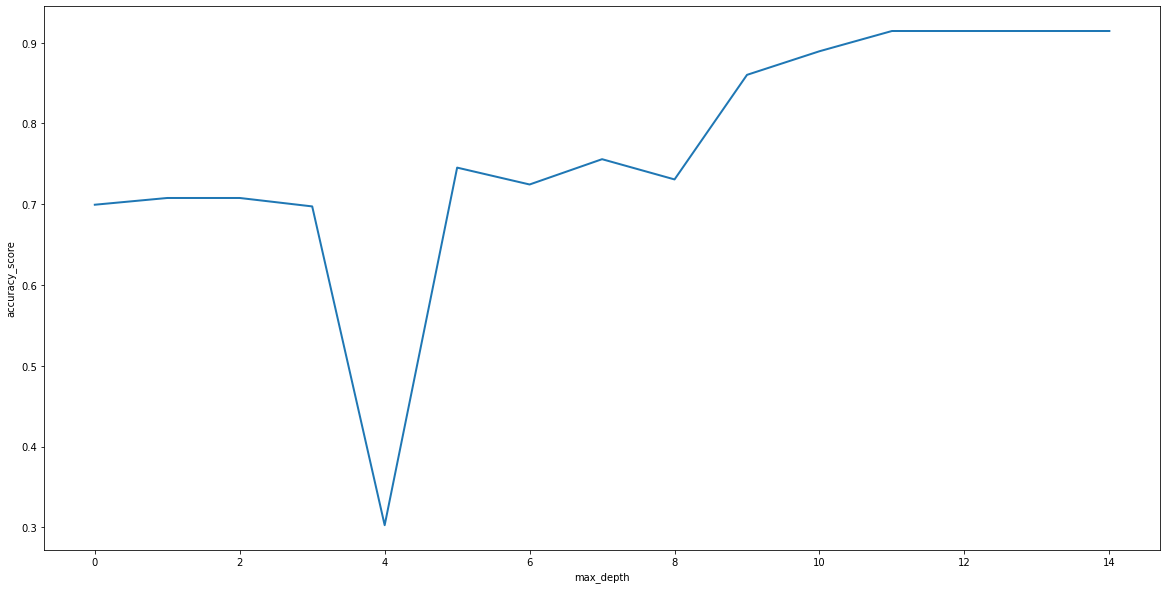

In [33]:
depths = [depth for depth in range(15)]
pred_for_max_depth = []

for depth in depths: 
    MyDT = DecisionTree([1 for i in range(X.shape[1])], max_depth=depth)
    MyDT.fit(np.array(X_train), np.array(y_train))
    pred_for_max_depth += [accuracy_score(MyDT.predict(np.array(X_test)), y_test)]
    
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('max_depth')
plt.plot(depths, pred_for_max_depth, linewidth=2)

In [34]:
#min_samples_split и min_samples_leaf

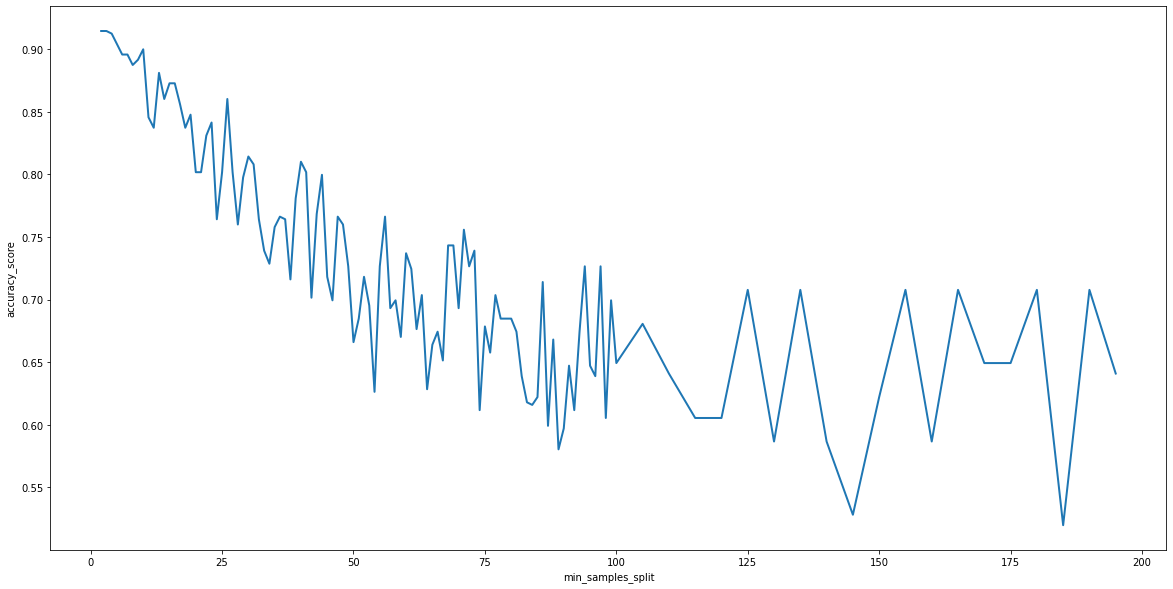

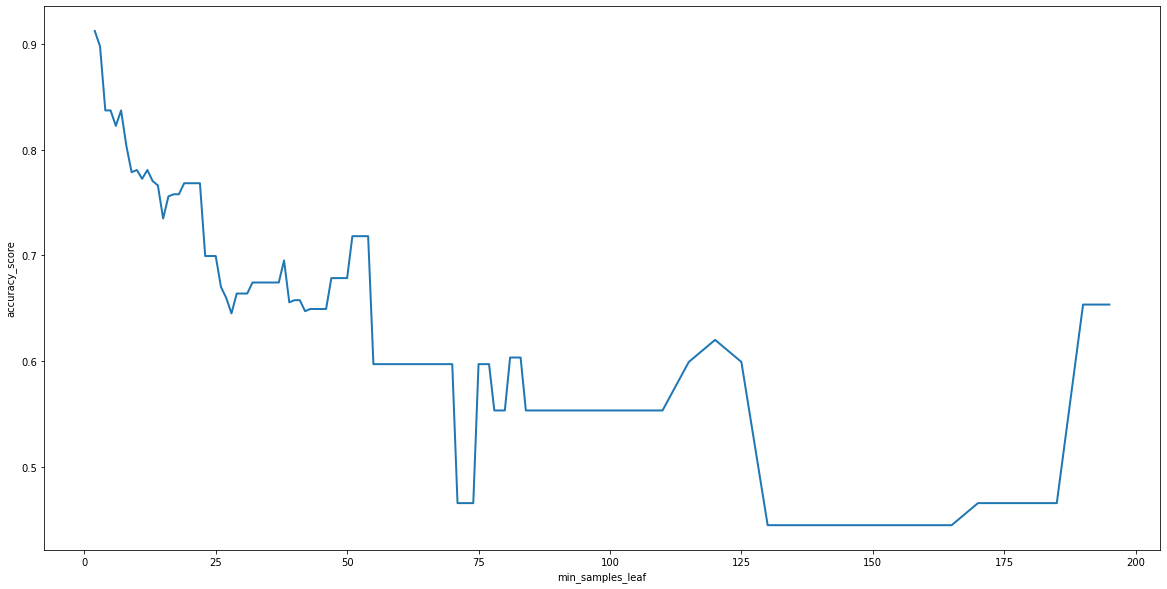

In [35]:
min_samp = [amount for amount in range(2, 100)] + [amount for amount in range(100, 200, 5)]
pred_for_min_samp_split = []
pred_for_min_samp_leaf = []

for min_s in min_samp: 
    MyDT = DecisionTree([1 for i in range(X.shape[1])], min_samples_split=min_s)
    MyDT.fit(np.array(X_train), np.array(y_train))
    pred_for_min_samp_split += [accuracy_score(MyDT.predict(np.array(X_test)), y_test)]
    MyDT = DecisionTree([1 for i in range(X.shape[1])], min_samples_leaf=min_s)
    MyDT.fit(np.array(X_train), np.array(y_train))
    pred_for_min_samp_leaf += [accuracy_score(MyDT.predict(np.array(X_test)), y_test)]
    
#Samp_split
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('min_samples_split')
plt.plot(min_samp, pred_for_min_samp_split, linewidth=2)

# Samp_leaf
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('min_samples_leaf')
plt.plot(min_samp, pred_for_min_samp_leaf, linewidth=2)

__12__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [36]:
X_mushroom = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/agaricus-lepiota.data', header = None)
X_cars = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/car.data', header = None)
X_nursery = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/nursery.data', header = None)
X_tic_tac_toe = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/tic-tac-toe.data', header = None)


pd.options.display.max_columns = 30

In [37]:
# Определяем две функции set_cars_class и set_nursery_class для преобразования целевых переменных в наборах данных car и nursery, соответственно.

def set_cars_class(x):
     return 0 if x in ['unacc', 'acc'] else 1


def set_nurcery_class(x):
    return 0 if x in ['not_recom', 'recommend'] else 1

# Применяем функции set_cars_class и set_nursery_class к последним столбцам наборов данных car и nursery и преобразует их целевые переменные.
X_cars[X_cars.shape[1] - 1] = X_cars[X_cars.shape[1] - 1].apply(set_cars_class)
X_nursery[X_nursery.shape[1] - 1] = X_nursery[X_nursery.shape[1] - 1].apply(set_nurcery_class)
# Разделяем каждый набор данных на целевую переменную и признаки.
y_cars = X_cars[X_cars.shape[1] - 1]
X_cars = X_cars.drop([X_cars.shape[1] - 1], 1)
y_nurcery = X_nursery[X_nursery.shape[1] - 1]
X_nurcery = X_nursery.drop([X_nursery.shape[1] - 1], 1)



# Кодируем категориальные признаки в наборах данных mushroom, tic-tac-toe, car и nursery с помощью класса LabelEncoder
le = LabelEncoder()
for X in [X_mushroom, X_tic_tac_toe, X_cars, X_nurcery]:
    for feature in X.columns:
        X[feature] = le.fit_transform(X[feature])

y_mushroom = X_mushroom[0]
X_mushroom = X_mushroom.drop([0], 1)
y_tic_tac_toe = X_tic_tac_toe[X_tic_tac_toe.shape[1] - 1]
X_tic_tac_toe = X_tic_tac_toe.drop([X_tic_tac_toe.shape[1] - 1], 1)

<ipython-input-37-7316e0b266df>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_cars = X_cars.drop([X_cars.shape[1] - 1], 1)
<ipython-input-37-7316e0b266df>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_nurcery = X_nursery.drop([X_nursery.shape[1] - 1], 1)
<ipython-input-37-7316e0b266df>:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_mushroom = X_mushroom.drop([0], 1)
<ipython-input-37-7316e0b266df>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_tic_tac_toe = X_tic_tac_toe.drop([X_tic_tac_toe.shape[1] - 1], 1)


In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

# По строкам наборы данных по столбцам алгоритмы

data_sets = [X_mushroom, X_tic_tac_toe, X_cars, X_nurcery]
data_targets = [y_mushroom, y_tic_tac_toe, y_cars, y_nurcery]

accuracy_scores = pd.DataFrame(columns=["DT_real_feat", "DT_cat_feat", "DT_one_hot_enc", "DTClassifier"],
                      index=["Mushroom", "Tic-tac-toe", "Cars", "Nurcery"])

# Применяем one-hot encoding к каждому набору данных, используя класс OneHotEncoder
for idx_d, data_set in enumerate(data_sets):

    ohe = OneHotEncoder(sparse=False)
    OneHotData = ohe.fit_transform(data_set)
    rools = [[0 for i in range(data_set.shape[1])],
             [1 for i in range(data_set.shape[1])],
             [0 for i in range(data_set.shape[1] + OneHotData.shape[1])],
             []]
    #Строим решающие деревья с использованием класса DecisionTree из библиотеки DecisionTree и класса DecisionTreeClassifier из библиотеки sklearn.tree 
    #на каждом из четырех наборов данных с использованием различных стратегий кодирования признаков и измеряет точность каждого дерева на основе кросс-валидации.
    for idx_r, regr_rool in enumerate(rools):
        DT = DecisionTree(types=regr_rool)
        if idx_r == 2:
            data_set = np.hstack((data_set, OneHotData))
        if idx_r == 3:
            DT = DecisionTreeClassifier()
        #Сохраняем результаты точности в DataFrame accuracy_scores для каждого набора данных и каждого типа стратегии кодирования признаков.            
        accuracy_scores.iloc[idx_d, idx_r] = cross_val_score(DT, np.array(data_set), np.array(data_targets[idx_d]), scoring=make_scorer(accuracy_score), cv=10).mean()

accuracy_scores

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

,DT_real_feat,DT_cat_feat,DT_one_hot_enc,DTClassifier
Mushroom,0.999261,1.0,0.999261,0.968265
Tic-tac-toe,0.462281,0.564397,0.534156,0.816469
Cars,0.943208,0.964048,0.917176,0.784447
Nurcery,0.999691,0.999846,0.999691,0.999691


__13__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Различия в ранжировке алгоритмов в разных датасетах обусловлены тем, что для некоторых признаков удобно использовать вещественные значения, а для других - нет. Например, количество дверей у машины можно интерпретировать как вещественное значение, а значения признаков в датасете tic-tac-toe можно использовать только как целочисленные (0, 1, 2). В случае с датасетом tic-tac-toe, мое дерево показывает плохие результаты, особенно на вещественных признаках. Это объясняется тем, что выявить закономерности сложно, когда все признаки примерно одинаковые. Кроме того, Sklearn работает лучше, возможно, из-за более глубокой построенной модели. В результатах кроссвалидации может быть присутствовать смещение, так как данные не перемешаны. В датасетах cars и nurcery выборка несбалансирована, что может давать некорректную оценку качества алгоритма. Можно попробовать подублировать объекты маленького класса или уменьшить количество объектов большого класса. Увеличение количества фолдов для кроссвалидации также может улучшить результаты, так как алгоритм будет обучаться на большем числе объектов.

# III. Композиции деревьев

### Задача 4. Сравнение композиционных методов над решающими деревьями



__14:__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [39]:
X_ = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР3/winequality-red.csv', sep=';')

In [40]:
y = X_['quality']
X = X_.drop(['quality'], 1)
X.head(1)

<ipython-input-40-c23e9268342b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X_.drop(['quality'], 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


* cross_val_score - функция из библиотеки scikit-learn, которая позволяет проводить кросс-валидацию для оценки качества модели. Она принимает на вход модель (DTC), матрицу признаков (X), вектор целевых переменных (y), а также опциональный параметр scoring, который определяет метрику для оценки качества модели (в данном случае это accuracy_score). Функция возвращает массив значений метрики для каждого фолда кросс-валидации.

* make_scorer - функция из библиотеки scikit-learn, которая позволяет создать функцию для оценки качества модели на основе любой метрики. В данном случае используется метрика accuracy_score, которая измеряет долю правильно классифицированных объектов.

* .mean() - это метод для вычисления среднего значения массива, возвращаемого функцией cross_val_score. Он используется для получения средней оценки качества модели на всех фолдах кросс-валидации.

Таким образом, код вычисляет и выводит на экран среднюю точность (accuracy) модели классификации DTC на всех фолдах кросс-валидации для заданных матрицы признаков X и вектора целевых переменных y.

In [41]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

DTC = DecisionTreeClassifier()
print("Среднее DTC", cross_val_score(DTC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC = BaggingClassifier(n_estimators=100, n_jobs=-1)
print("Среднее BC", cross_val_score(BC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC_half_feat = BaggingClassifier(n_estimators=100, n_jobs=-1, max_features=0.5)
print("Среднее BC_half_feat", cross_val_score(BC_half_feat, X, y, scoring=make_scorer(accuracy_score)).mean())
RFC = RandomForestClassifier(n_estimators=100, n_jobs=-1)
print("Среднее RFC", cross_val_score(RFC, X, y, scoring=make_scorer(accuracy_score)).mean())

Среднее DTC 0.4759012539184953
Среднее BC 0.5647257053291537
Среднее BC_half_feat 0.562840909090909
Среднее RFC 0.5647217868338558


### Задача 5. Число деревьев в случайном лесе


В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__15__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [42]:
X = X_.iloc[np.random.permutation(len(X))] # Случайная перестановка индексов строк из исходного датафрейме X_
y = X['quality']
X = X.drop(['quality'], 1)
X.head(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-42-de0b8c27f3ec>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop(['quality'], 1)


Text(0, 0.5, 'Точность')

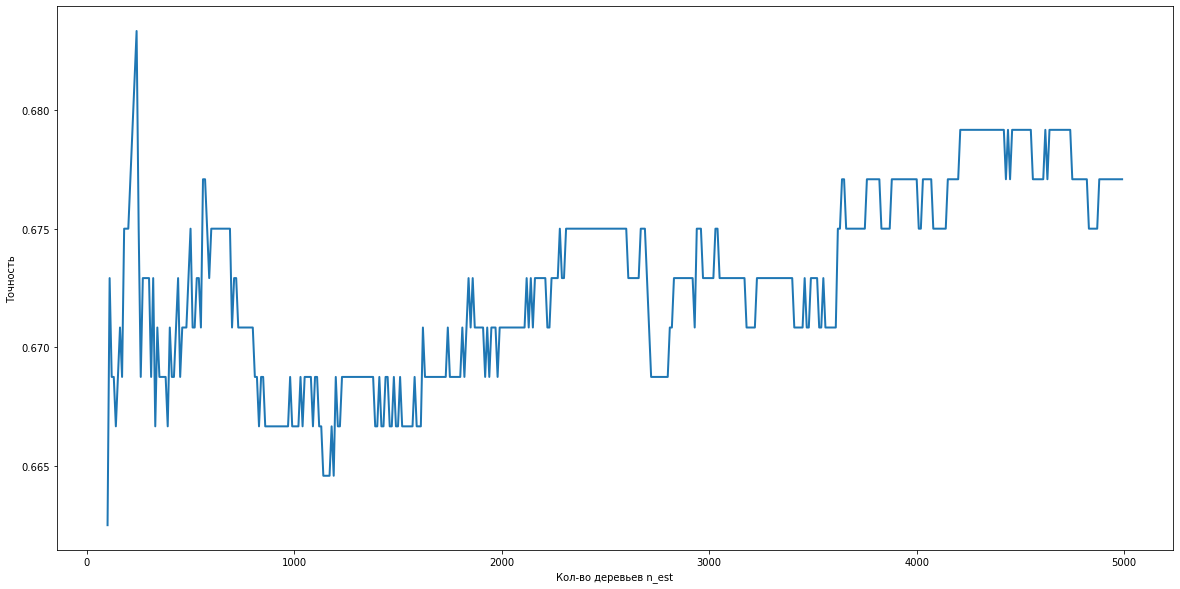

In [43]:
accuracy_scores = []
RF = RandomForestClassifier(warm_start=True, n_estimators=100, n_jobs=-1)
RF.fit(X_train, y_train)
accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))
for n_est in range(110, 5000, 10):
    RF.set_params(n_estimators=n_est)
    RF.fit(X_train, y_train)
    accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot([n_est for n_est in range(100, 5000, 10)], accuracy_scores, linewidth=2)
plt.xlabel('Кол-во деревьев n_est')
plt.ylabel('Точность')

Исходя из результатов, если увеличивать количество деревьев в ансамбле, то можно заметить, что доля верных ответов на обучающей выборке может улучшаться, но на тестовой выборке она начинает ухудшаться, что свидетельствует о переобучении модели. Теоретически, увеличение числа деревьев должно снизить отклонение, но повысить дисперсию модели, что может привести к настройке на выбросы и снижению обобщающей способности ансамбля.